# Importing Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping

2022-11-04 04:10:58.812353: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Load Dataset

In [2]:
path = '../input/surface-crack-detection/'
path_all = list(glob.glob(path+'**/*jpg'))
path_Negative = path + 'Negative/*.jpg'
path_Positive = path + 'Positive/*.jpg'

# Visualizing the Dataset

Text(0.5, 1.0, 'Negative and Positive')

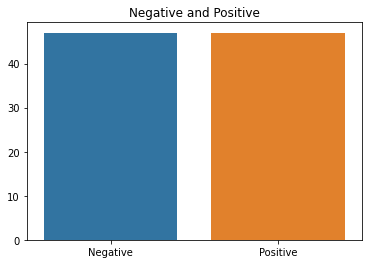

In [3]:
sns.barplot(x=['Negative','Positive'], y=[len(path_Negative), len(path_Positive)])
plt.title('Negative and Positive')

In [4]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Label
0,../input/surface-crack-detection/Positive/1820...,Positive
1,../input/surface-crack-detection/Positive/1242...,Positive
2,../input/surface-crack-detection/Positive/0358...,Positive
3,../input/surface-crack-detection/Positive/0494...,Positive
4,../input/surface-crack-detection/Negative/1483...,Negative


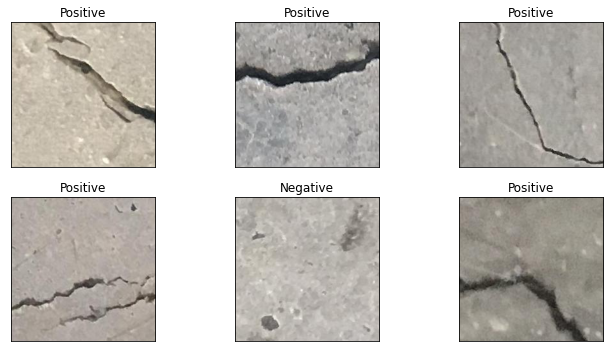

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

# Train & Test Split

In [6]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Functions

In [7]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.2)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=42
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=False,
        seed=42
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [8]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
    return model, my_callbacks

In [9]:
def plot(history,df_test,test_gen,train_gen):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(df_test.Label,pred)
    clr = classification_report(df_test.Label, pred, target_names=["NEGATIVE", "POSITIVE"])
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.File_Path.iloc[i+1]))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [10]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

# VGG16

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)

Found 32000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [12]:
model, callback=func(VGG16)

2022-11-04 04:13:09.112989: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-04 04:13:09.116750: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-04 04:13:09.182798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 04:13:09.183593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-11-04 04:13:09.183665: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-11-04 04:13:09.215773: I tensorflow/stream_executor/platform/def

58892288/58889256 [==============================] - 0s 0us/step


In [13]:
history = model.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=100,
    callbacks=callback
)

2022-11-04 04:13:12.693820: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-04 04:13:12.698195: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


Epoch 1/100


2022-11-04 04:13:13.466945: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-11-04 04:13:14.443059: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-11-04 04:13:14.471201: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


500/500 [==============================] - 296s 575ms/step - loss: 0.0896 - accuracy: 0.9664 - val_loss: 0.0076 - val_accuracy: 0.9979
Epoch 2/100
500/500 [==============================] - 122s 244ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0030 - val_accuracy: 0.9991
Epoch 3/100
500/500 [==============================] - 121s 242ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.0021 - val_accuracy: 0.9993
Epoch 4/100
500/500 [==============================] - 136s 272ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0010 - val_accuracy: 0.9998
Epoch 5/100
500/500 [==============================] - 147s 294ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 7.0284e-04 - val_accuracy: 0.9998
Epoch 6/100
500/500 [==============================] - 127s 253ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0014 - val_accuracy: 0.9995


              precision    recall  f1-score   support

    NEGATIVE       1.00      0.99      1.00      4033
    POSITIVE       0.99      1.00      1.00      3967

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



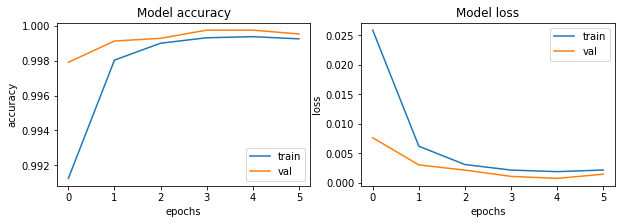

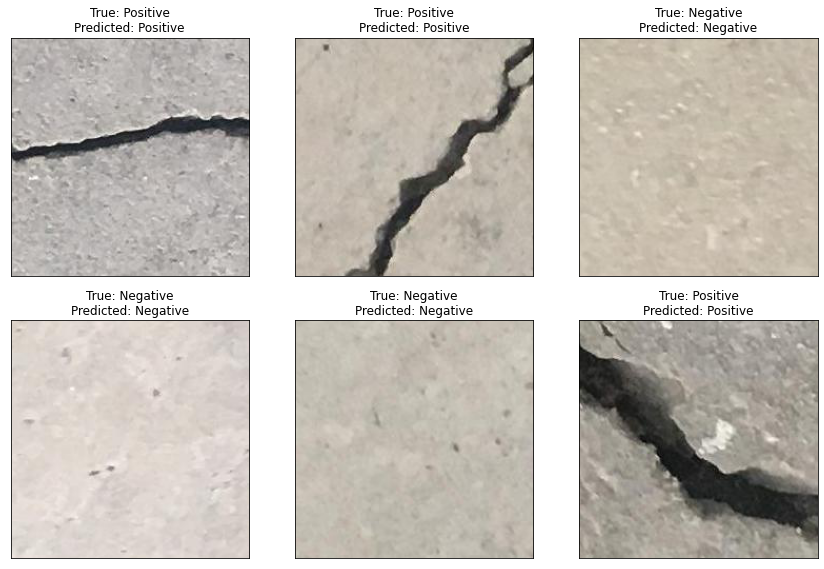

In [14]:
history=plot(history,test_df,test_gen_VGG,train_gen_VGG)

In [15]:
result = result_test(test_gen_VGG,model)

    Test Loss: 0.01455
Test Accuracy: 99.58%


# ResNet50 

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
RestNet_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = gen(RestNet_pre,train_df,test_df)

Found 32000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [17]:
ResNet50_model, callback=func(ResNet50)

94773248/94765736 [==============================] - 1s 0us/step


In [18]:
history = ResNet50_model.fit(
    train_gen_RestNet,
    validation_data=valid_gen_RestNet,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
500/500 [==============================] - 134s 261ms/step - loss: 0.0269 - accuracy: 0.9917 - val_loss: 0.0034 - val_accuracy: 0.9987
Epoch 2/100
500/500 [==============================] - 125s 250ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.0105 - val_accuracy: 0.9964


              precision    recall  f1-score   support

    NEGATIVE       1.00      0.99      1.00      4033
    POSITIVE       0.99      1.00      1.00      3967

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



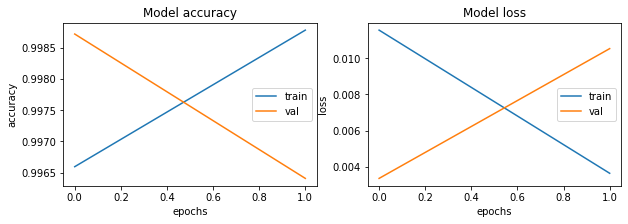

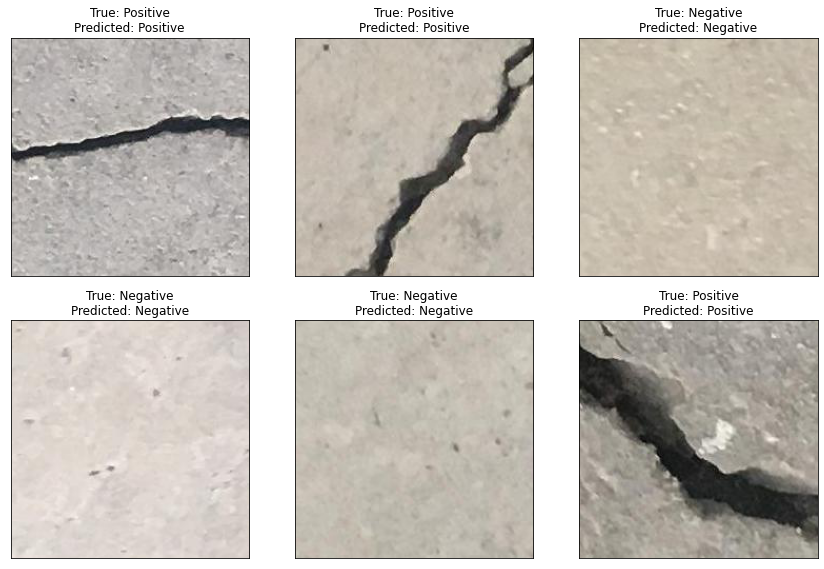

In [19]:
history_ResNet=plot(history,test_df,test_gen_RestNet,train_gen_RestNet)

In [20]:
result_ResNet = result_test(test_gen_RestNet,ResNet50_model)

    Test Loss: 0.02069
Test Accuracy: 99.50%


In [21]:
result_ResNet

[0.020694082602858543, 0.9950000047683716]

# Xception

In [22]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
Xception_pre=preprocess_input
train_gen_Xception, valid_gen_Xception, test_gen_Xception = gen(Xception_pre,train_df,test_df)

Found 32000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [23]:
Xception_model, callback=func(Xception)

83689472/83683744 [==============================] - 1s 0us/step


In [24]:
history = Xception_model.fit(
    train_gen_Xception,
    validation_data=valid_gen_Xception,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
500/500 [==============================] - 123s 241ms/step - loss: 0.0861 - accuracy: 0.9658 - val_loss: 0.0160 - val_accuracy: 0.9951
Epoch 2/100
500/500 [==============================] - 118s 236ms/step - loss: 0.0104 - accuracy: 0.9969 - val_loss: 0.0045 - val_accuracy: 0.9988
Epoch 3/100
500/500 [==============================] - 117s 234ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0029 - val_accuracy: 0.9992
Epoch 4/100
500/500 [==============================] - 118s 237ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0015 - val_accuracy: 0.9996
Epoch 5/100
500/500 [==============================] - 117s 235ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0021 - val_accuracy: 0.9994


              precision    recall  f1-score   support

    NEGATIVE       0.64      1.00      0.78      4033
    POSITIVE       1.00      0.42      0.59      3967

    accuracy                           0.71      8000
   macro avg       0.82      0.71      0.69      8000
weighted avg       0.82      0.71      0.69      8000



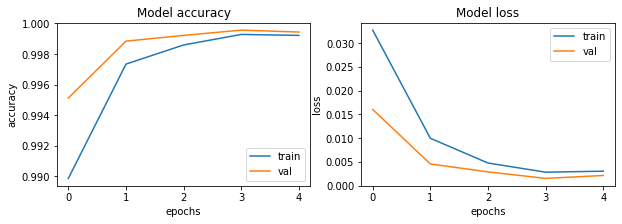

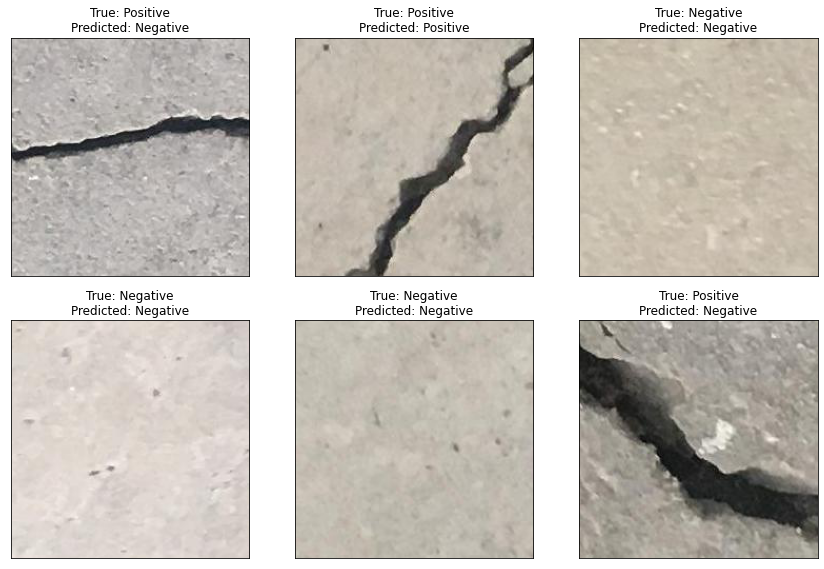

In [25]:
history_Xception=plot(history,test_df,test_gen_Xception,train_gen_Xception)

In [26]:
result_Xception = result_test(test_gen_Xception,Xception_model)

    Test Loss: 0.01423
Test Accuracy: 99.69%


# MobileNet 

In [27]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)

Found 32000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [28]:
MobileNet_model, callback=func(MobileNet)

17227776/17225924 [==============================] - 0s 0us/step


In [29]:
history_MobileNet = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
500/500 [==============================] - 115s 227ms/step - loss: 0.0714 - accuracy: 0.9737 - val_loss: 0.0064 - val_accuracy: 0.9980
Epoch 2/100
500/500 [==============================] - 113s 227ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 0.9996
Epoch 3/100
500/500 [==============================] - 114s 228ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0012 - val_accuracy: 0.9996
Epoch 4/100
500/500 [==============================] - 114s 228ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 5.3766e-04 - val_accuracy: 0.9999
Epoch 5/100
500/500 [==============================] - 112s 224ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.0023 - val_accuracy: 0.9989


              precision    recall  f1-score   support

    NEGATIVE       0.64      1.00      0.78      4033
    POSITIVE       1.00      0.42      0.59      3967

    accuracy                           0.71      8000
   macro avg       0.82      0.71      0.69      8000
weighted avg       0.82      0.71      0.69      8000



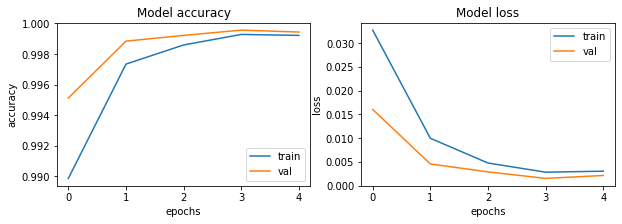

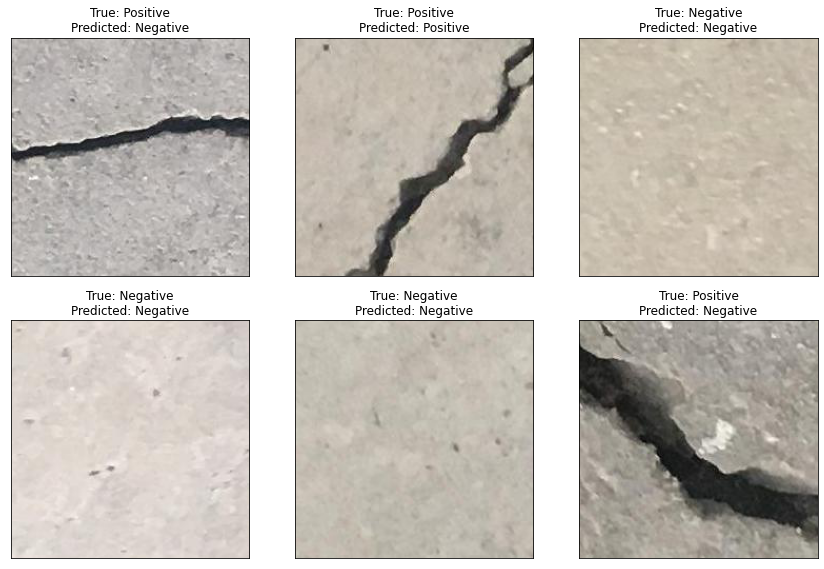

In [30]:
history=plot(history,test_df,test_gen_MobileNet,train_gen_MobileNet)

In [31]:
result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

    Test Loss: 0.01302
Test Accuracy: 99.70%


# Final Report

In [32]:
output = pd.DataFrame({'Model':['VGG16','ResNet50','Xception','MobileNet'],
                      'Accuracy':[result[1], result_ResNet[1], result_Xception[1], result_MobileNet[1]]})

In [33]:
output

,Model,Accuracy
0,VGG16,0.995750
1,ResNet50,0.995000
2,Xception,0.996875
3,MobileNet,0.997000


[(0.994, 0.9995)]

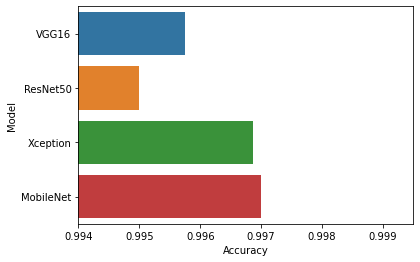

In [35]:
ax=sns.barplot(x='Accuracy', y='Model', data=output)
ax.set(xlim = (0.994, 0.9995))
